### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [7]:
from src.load_datasets import load_power_consumption


dataframe = (
    load_power_consumption()
    .pipe(format_datetime, col="DateTime")
    .pipe(set_index, col="DateTime")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")


dataframe.head()

format_datetime: DF Shape (52416, 9)
set_index: DF Shape (52416, 8)
resample_Data: DF Shape (8736, 8)
dataframe shape (8736, 8)


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


In [8]:
dataframe.isna().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

In [9]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
Temperature,1.000000,-0.459387,0.479446,0.464366,0.202537,0.443863,0.384833,0.492124
Humidity,-0.459387,1.000000,-0.136835,-0.473566,-0.266270,-0.290764,-0.297885,-0.235100
Wind Speed,0.479446,-0.136835,1.000000,0.136046,-0.001090,0.169573,0.147999,0.280995
general diffuse flows,0.464366,-0.473566,0.136046,1.000000,0.576290,0.191831,0.159858,0.064914
diffuse flows,0.202537,-0.266270,-0.001090,0.576290,1.000000,0.087430,0.049046,-0.037074
Zone 1 Power Consumption,0.443863,-0.290764,0.169573,0.191831,0.087430,1.000000,0.834165,0.750057
Zone 2 Power Consumption,0.384833,-0.297885,0.147999,0.159858,0.049046,0.834165,1.000000,0.568448
Zone 3 Power Consumption,0.492124,-0.235100,0.280995,0.064914,-0.037074,0.750057,0.568448,1.000000


### Test Train split

train_xy and test_xy size: (8721, 8), (15, 8)

y_train and x_train size (8721,), (8721, 7)
y_test  and x_test  size (15,),  (15, 7)



(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Zone 3  Power Consumption'>)

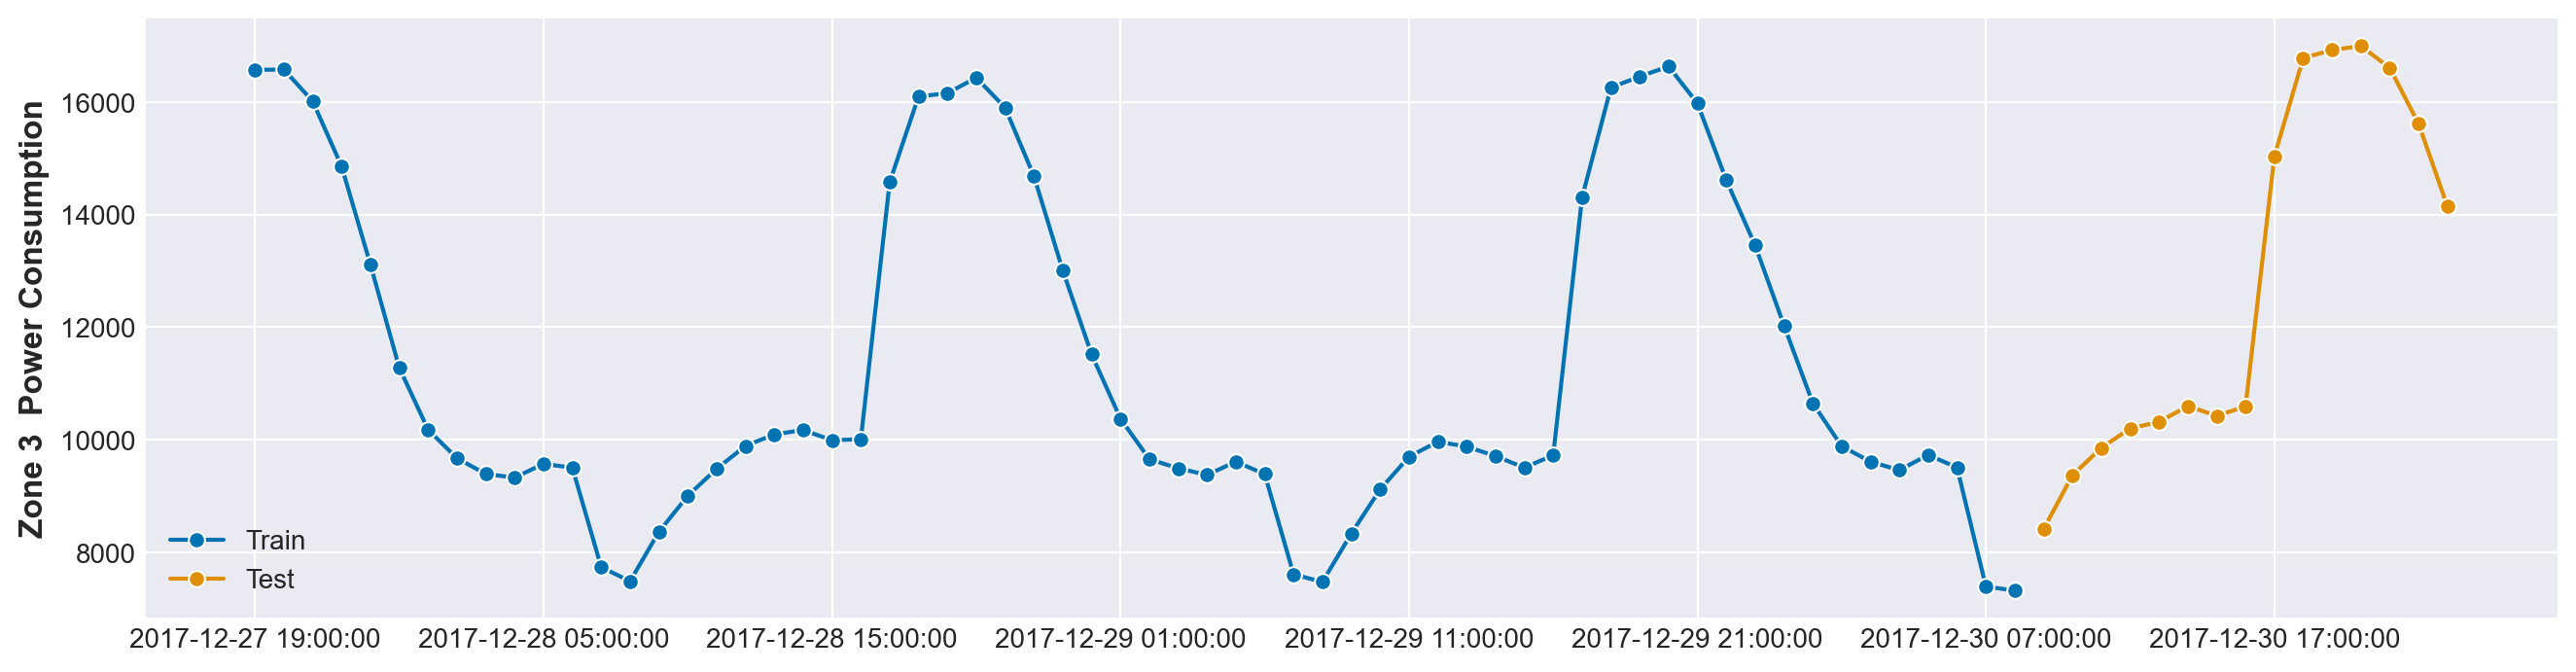

In [12]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Zone 3  Power Consumption"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 8646 , step_length 15 for fold 5


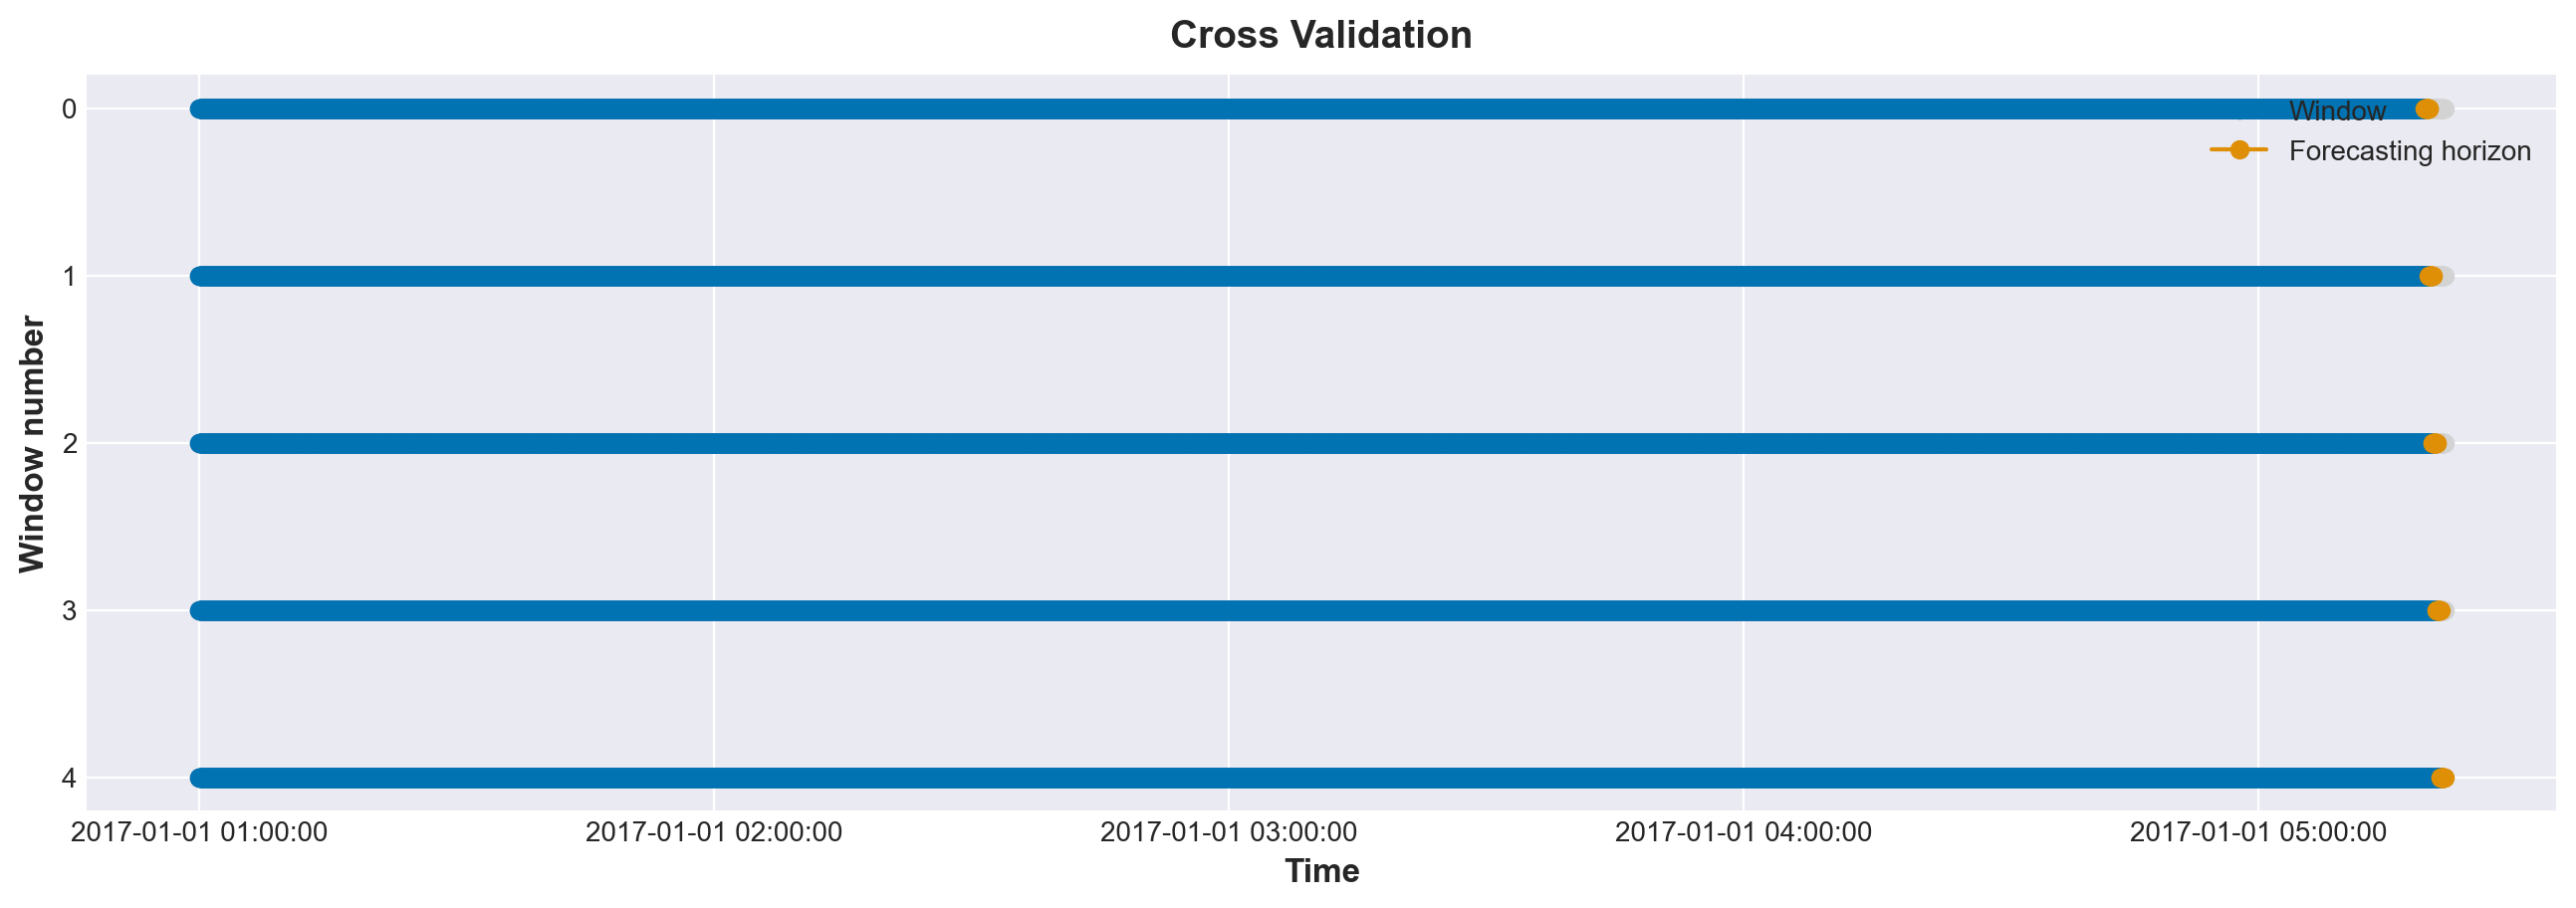

In [14]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [26]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.linear_model import Lasso

    print("Importing sklearnex Ridge")
except ImportError:
    from sklearn.linear_model import Lasso

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
    "forecaster__reducer__estimator__alpha": [0.01, 0.1, 1, 10],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=Lasso(random_state=80),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Importing sklearnex Ridge
Number of CPU Count:   12
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 1, 'forecaster__reducer__estimator__alpha': 10, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__window_length': 24, 'scaler_x__passthrough': False}
Best scores 468.0332563589665
CPU times: total: 250 ms
Wall time: 19.8 s


In [27]:
print(x_test.columns)

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption'],
      dtype='object')


2017-12-30 09:00:00     8588.190288
2017-12-30 10:00:00     9534.654838
2017-12-30 11:00:00    10069.104637
2017-12-30 12:00:00    10342.594464
2017-12-30 13:00:00    10188.551970
2017-12-30 14:00:00     9950.869130
2017-12-30 15:00:00     9384.953371
2017-12-30 16:00:00     9913.974095
2017-12-30 17:00:00    13295.807450
2017-12-30 18:00:00    16209.069072
2017-12-30 19:00:00    17494.523343
2017-12-30 20:00:00    17164.864249
2017-12-30 21:00:00    16083.212598
2017-12-30 22:00:00    14633.882208
2017-12-30 23:00:00    12919.695097
Freq: H, Name: Zone 3  Power Consumption, dtype: float64

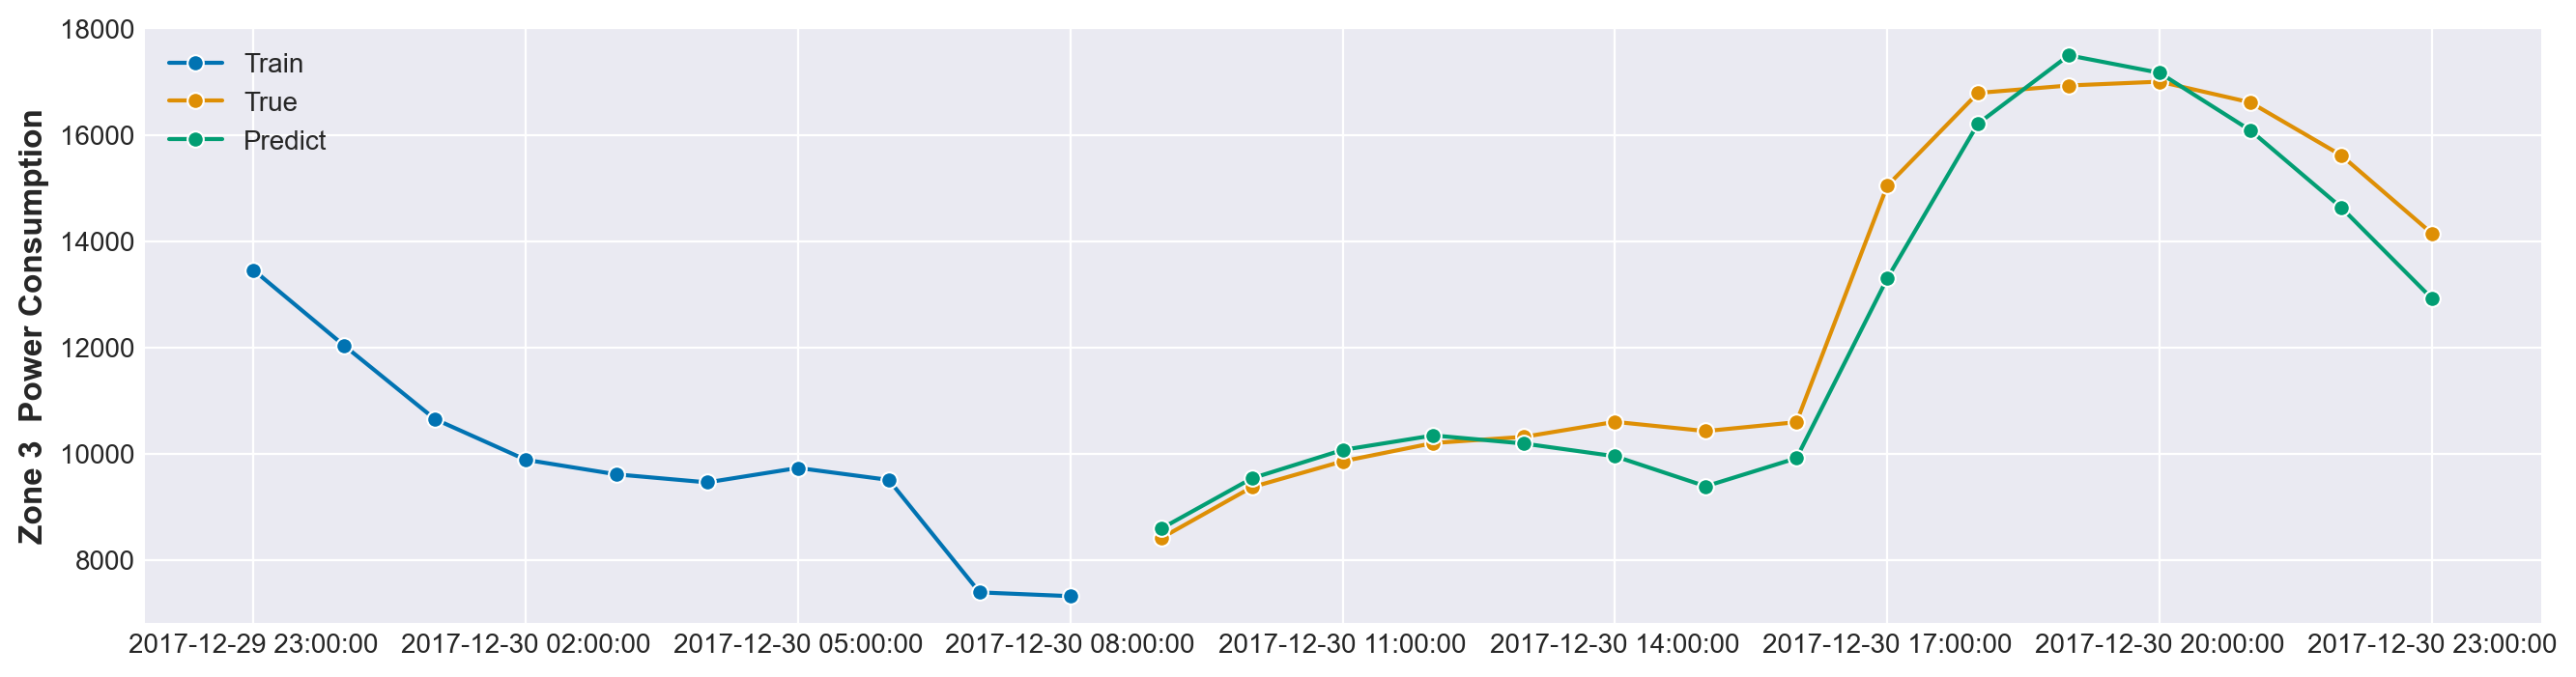

In [28]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [29]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(32, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,515.158576,0.186825,1.032788,{'forecaster__deseasonalizer__model': 'additiv...,24.0
1,515.072556,0.184367,1.157170,{'forecaster__deseasonalizer__model': 'additiv...,21.0
2,507.389537,0.158468,1.203969,{'forecaster__deseasonalizer__model': 'additiv...,11.0
3,512.451605,0.173022,1.265963,{'forecaster__deseasonalizer__model': 'additiv...,18.0
4,515.156800,0.165385,1.236452,{'forecaster__deseasonalizer__model': 'additiv...,23.0


### Backtesting Insample Prediction

In [30]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,554.749371,0.132363,0.579768,8646,2017-12-27 05:00:00,2017-01-01 00:00:00 19252.048193 2017-01-01...,DateTime 2017-12-27 06:00:00 9633.613444 2...,2017-12-27 06:00:00 9066.483082 2017-12-27...,436.319516,0.037059,0.321114
1,589.469015,0.110038,0.487440,8661,2017-12-27 20:00:00,2017-01-01 00:00:00 19252.048193 2017-01-01...,DateTime 2017-12-27 21:00:00 16014.405762 2...,2017-12-27 21:00:00 15749.329732 2017-12-27...,494.914111,0.050069,0.364508
2,676.666680,0.066050,0.439457,8676,2017-12-28 11:00:00,2017-01-01 00:00:00 19252.048193 2017-01-01...,DateTime 2017-12-28 12:00:00 9889.075630 2...,2017-12-28 12:00:00 10395.030443 2017-12-28...,555.624101,0.044400,0.409526
3,422.180594,0.108737,0.583484,8691,2017-12-29 02:00:00,2017-01-01 00:00:00 19252.048193 2017-01-01...,DateTime 2017-12-29 03:00:00 9491.476591 2...,2017-12-29 03:00:00 9154.216801 2017-12-29...,371.863284,0.038052,0.274230
4,582.106061,0.108990,0.577963,8706,2017-12-29 17:00:00,2017-01-01 00:00:00 19252.048193 2017-01-01...,DateTime 2017-12-29 18:00:00 16258.343338 2...,2017-12-29 18:00:00 16867.858425 2017-12-29...,481.445269,0.040586,0.355340


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Zone 3  Power Consumption'>)

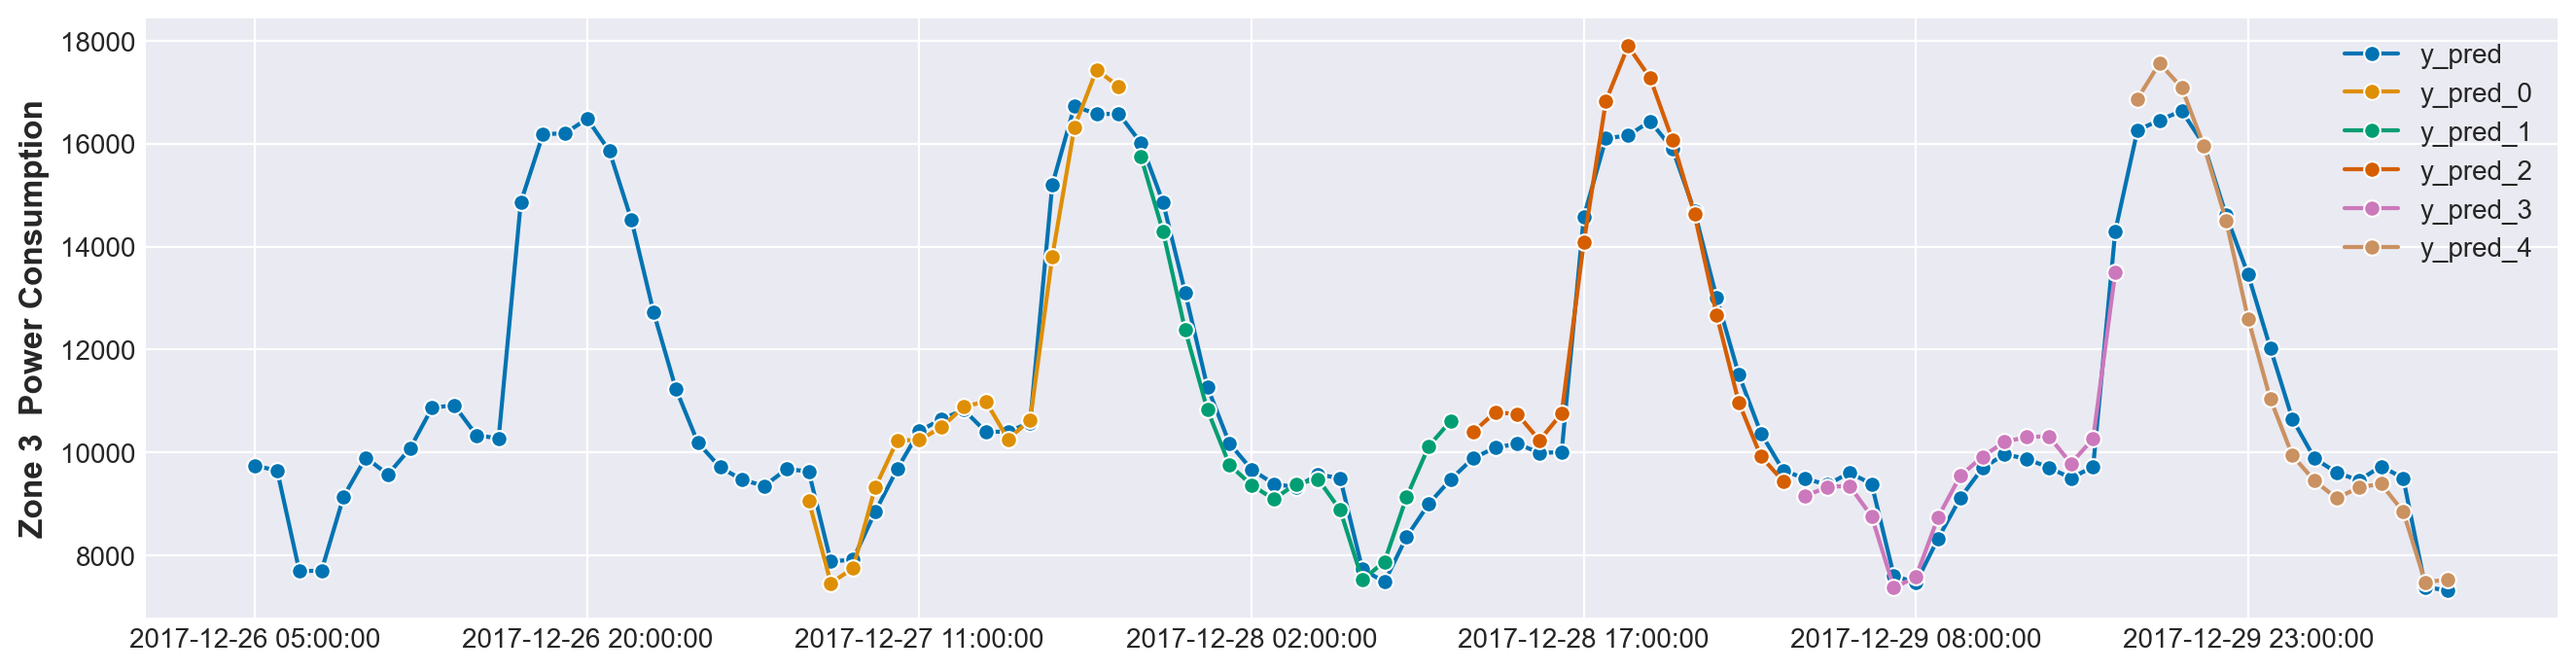

In [31]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [32]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster())),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=Lasso(alpha=10, fit_intercept=False, random_state=80),
                                                                          pooling='global',
                                                                          window_length=24))]),
 'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x',
   OptionalPassthrough(transformer=TabularToSeries

### Train Model Parameter

In [33]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 31

model_fname_in ['Zone 3  Power Consumption_lag_1' 'Zone 3  Power Consumption_lag_2'
 'Zone 3  Power Consumption_lag_3' 'Zone 3  Power Consumption_lag_4'
 'Zone 3  Power Consumption_lag_5' 'Zone 3  Power Consumption_lag_6'
 'Zone 3  Power Consumption_lag_7' 'Zone 3  Power Consumption_lag_8'
 'Zone 3  Power Consumption_lag_9' 'Zone 3  Power Consumption_lag_10'
 'Zone 3  Power Consumption_lag_11' 'Zone 3  Power Consumption_lag_12'
 'Zone 3  Power Consumption_lag_13' 'Zone 3  Power Consumption_lag_14'
 'Zone 3  Power Consumption_lag_15' 'Zone 3  Power Consumption_lag_16'
 'Zone 3  Power Consumption_lag_17' 'Zone 3  Power Consumption_lag_18'
 'Zone 3  Power Consumption_lag_19' 'Zone 3  Power Consumption_lag_20'
 'Zone 3  Power Consumption_lag_21' 'Zone 3  Power Consumption_lag_22'
 'Zone 3  Power Consumption_lag_23' 'Zone 3  Power Consumption_lag_24'
 'Temperature' 'Humidity' 'Wind Speed' 'general diffuse flows'
 'diffuse flows' 'Zone 1 Power Consumption' 'Zone 2  Po

### model cutoff

In [34]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2017-12-30 08:00:00'], dtype='datetime64[ns]', name='DateTime', freq='H') 2017-12-30 08:00:00


### Model Cloning

In [35]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_defa

### Model saving 

In [36]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/Lasso.pkl")

['../results/Lasso.pkl']

### Features importance

<Axes: >

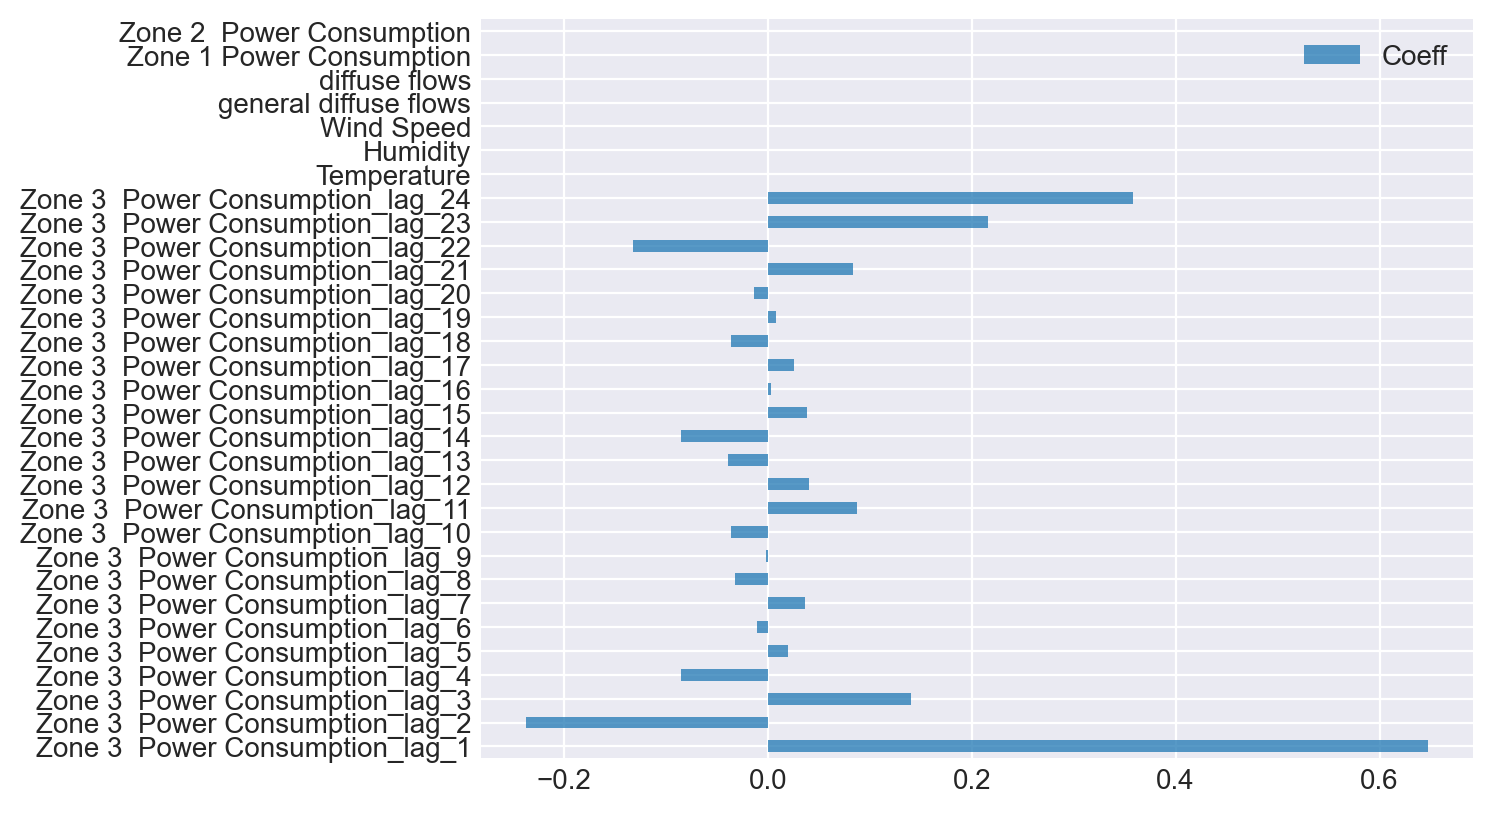

In [37]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)